In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv("jobs_in_data.csv")

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 10000

# Feature 1:
# Calculate the ratio of "salary_in_usd" to "salary"
df['salary_ratio'] = df['salary_in_usd'] / df['salary']

# Feature 2:
experience_mapping = {
    'Entry-level': 1,
    'Mid-level': 2,
    'Senior': 3,
    'Executive': 4
}

# Map experience levels to ordinal numbers
df['experience_level_encoded'] = df['experience_level'].map(experience_mapping)


# Feature 3:
# Calculate the percentile rank of each salary within its job category
df['Percentile'] = df.groupby('job_category')['salary'].rank(pct=True)

# Normalize the percentile ranks to a scale of 0 to 1
min_percentile = df['Percentile'].min()
max_percentile = df['Percentile'].max()
df['Normalized_Salary_within_Job_Category'] = (df['Percentile'] - min_percentile) / (max_percentile - min_percentile)

# Drop the temporary 'Percentile' column if you don't need it anymore
df.drop(columns=['Percentile'], inplace=True)

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(
    columns=["salary_in_usd", "salary"])  # Select only numeric columns
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.0)(lstm_layer)
lstm_layer2 = LSTM(64)(dropout_layer)
output_layer = Dense(1, activation='linear')(lstm_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])


# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
# print("MSE:", mse)
print("RMSE:", np.sqrt(mse))


Epoch 1/100
106/106 [==============================] - 5s 14ms/step - loss: 52.1914 - mse: 52.1914 - val_loss: 40.3778 - val_mse: 40.3778
Epoch 2/100
106/106 [==============================] - 1s 6ms/step - loss: 39.6434 - mse: 39.6434 - val_loss: 40.6043 - val_mse: 40.6043
Epoch 3/100
106/106 [==============================] - 1s 7ms/step - loss: 39.7233 - mse: 39.7233 - val_loss: 40.3790 - val_mse: 40.3790
Epoch 4/100
106/106 [==============================] - 1s 6ms/step - loss: 39.7985 - mse: 39.7985 - val_loss: 40.3619 - val_mse: 40.3619
Epoch 5/100
106/106 [==============================] - 1s 7ms/step - loss: 39.6502 - mse: 39.6502 - val_loss: 40.4953 - val_mse: 40.4953
Epoch 6/100
106/106 [==============================] - 1s 8ms/step - loss: 39.2396 - mse: 39.2396 - val_loss: 39.0176 - val_mse: 39.0176
Epoch 7/100
106/106 [==============================] - 1s 7ms/step - loss: 29.5815 - mse: 29.5815 - val_loss: 9.4023 - val_mse: 9.4023
Epoch 8/100
106/106 [=====================

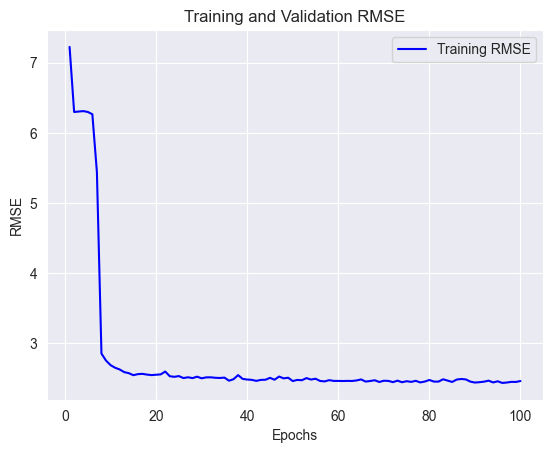

In [3]:
# Extract RMSE values from the training history
train_rmse = np.sqrt(history.history['mse'])

# Plot RMSE vs. epochs
epochs = range(1, len(train_rmse) + 1)

plt.figure(facecolor='white')  # Set white background
plt.plot(epochs, train_rmse, 'b', label='Training RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()
